In [1]:
import pickle
from glob import glob 

import pandas as pd
from tqdm import tqdm 
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torchmetrics
from umap import UMAP

from erc.constants import idx2emotion

sns.set_theme()

In [2]:
# load pickle --> RAM 
SAVE_PATH = "./RobertaL_valid_results"

total_emotion = pd.DataFrame()
total_emb = pd.DataFrame()
total_logits = pd.DataFrame()

result_fnames = glob(SAVE_PATH+'/*.pickle')
pbar = tqdm(total=len(result_fnames), 
            iterable=result_fnames)

target_layer = 15
for pickle_name in pbar:
    # load
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    # print(data)
    tmp_emotion = pd.DataFrame(data['emotion'].detach().numpy())
    tmp_linear = pd.DataFrame(data[target_layer].cpu().numpy())
    pred = data[16][:, :-2]
    tmp_pred = pd.DataFrame(pred.argmax(dim=1).cpu().numpy())
    tmp_logits = pd.DataFrame(pred.cpu().numpy())
    
    total_logits = pd.concat(objs=[total_logits, tmp_logits])
    
    total_emotion = pd.concat(objs=[total_emotion,
                                    pd.concat([tmp_emotion, tmp_pred], axis=1)],
                              axis=0)
    total_emb = pd.concat([total_emb, tmp_linear], axis=0)

del tmp_emotion
del tmp_linear

total_emotion.columns = ['emotion', "pred"]

100%|██████████| 585/585 [00:03<00:00, 156.47it/s]


In [3]:
acc = torchmetrics.Accuracy(task="multiclass", num_classes=7)

In [4]:
correct_indices = (total_emotion.emotion == total_emotion.pred).values
incorrect_indices = (total_emotion.emotion != total_emotion.pred).values

correct_indices.sum(), incorrect_indices.sum()

(4004, 674)

In [5]:
acc(
    target=torch.from_numpy(total_emotion.emotion.values),
    preds=torch.from_numpy(total_logits.values)
)

tensor(0.8559)

In [32]:
def plot_rd(data: np.ndarray,
            total_emotion: pd.DataFrame,
            correct_only: bool = True,
            incorrect_only: bool = False,
            dim_reduction: str = "pca",
            n_components: int = 2,
            n_sampling: int = 100,
            use_jointplot: bool = False,
            title: str = "",
            remove_neutral: bool = False,
            **kwargs):
    
    # Umap config
    if dim_reduction == "umap":
        if kwargs.get("n_neighbors"):
            kwargs["n_neighbors"] = 7
        if kwargs.get("min_dist"):
            kwargs["n_neighbors"] = 0

    # Dimensionality Reduction
    if dim_reduction is not None:
        tool = {
            "pca": PCA,
            "tsne": TSNE,
            "umap": UMAP,
        }[dim_reduction](n_components=n_components, **kwargs)
        reduced_data = tool.fit_transform(data)
    else:
        # Pre-transformed data
        reduced_data = data
    # Sample correct
    if correct_only:
        correct_indices = (total_emotion.emotion == total_emotion.pred).values
        reduced_data = reduced_data[correct_indices]
        total_emotion = total_emotion[correct_indices]
    if incorrect_only:
        incorrect_indices = (total_emotion.emotion != total_emotion.pred).values
        reduced_data = reduced_data[incorrect_indices]
        total_emotion = total_emotion[incorrect_indices]

    if n_sampling > 0:
        tmp = pd.DataFrame()
        for emotion in total_emotion.emotion.unique():
            _sub_df = total_emotion[total_emotion.emotion == emotion]
            ns = min(len(_sub_df), n_sampling)
            _sub_df = _sub_df.sample(n=ns)
            tmp = pd.concat([tmp, _sub_df])
        total_emotion = tmp
    
    if not use_jointplot:
        x, y = np.split(reduced_data.T, indices_or_sections=2)
        x, y = x.squeeze(), y.squeeze()
        for idx, emotion in idx2emotion.items():
            if emotion == "neutral" and remove_neutral:
                continue
            mask = (total_emotion.emotion == idx).values
            plt.scatter(x=x[mask], y=y[mask], label=emotion, marker='.', alpha=0.7)
            
        if title == "":
            title = f"{dim_reduction.upper()}"
        plt.title(label=title, size="x-large")
        plt.legend();
    else:
        if remove_neutral:
            reduced_data = reduced_data[total_emotion.emotion != "neutral"]

        total_df = pd.DataFrame(reduced_data)
        total_df.columns = ["dim1", "dim2"]
        total_df["emotion"] = total_emotion.emotion.apply(idx2emotion.get).values
        sns.jointplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                      kind="kde", palette="pastel", fill=True, alpha=0.6)
        sns.move_legend

## PCA

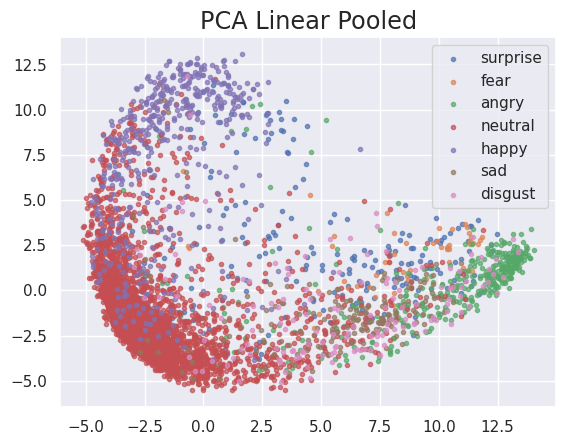

In [21]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=False,
        incorrect_only=False,
        title="PCA Linear Pooled",
        n_sampling=0,
        random_state=42)

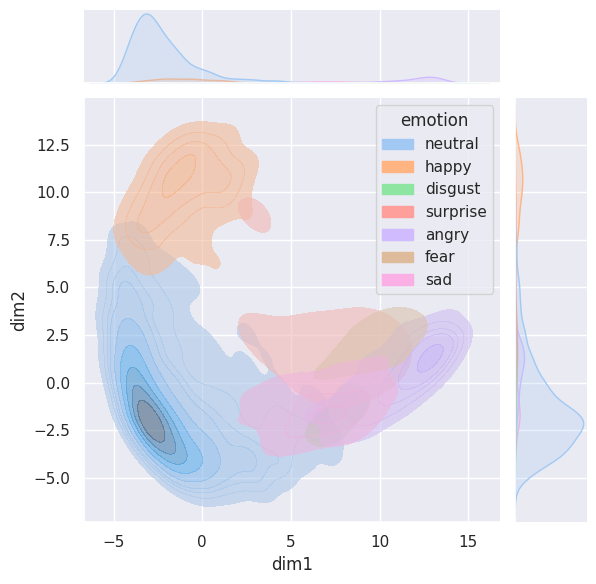

In [33]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=True,
        incorrect_only=False,
        title="PCA Linear Pooled | Correct Only",
        n_sampling=0,
        use_jointplot=True,
        random_state=42)

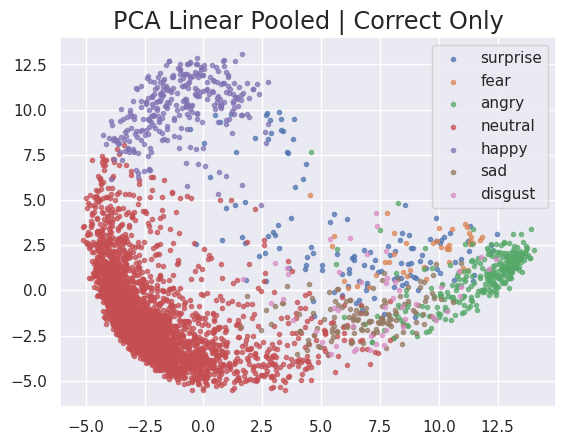

In [17]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=True,
        incorrect_only=False,
        title="PCA Linear Pooled | Correct Only",
        n_sampling=0,
        random_state=42)

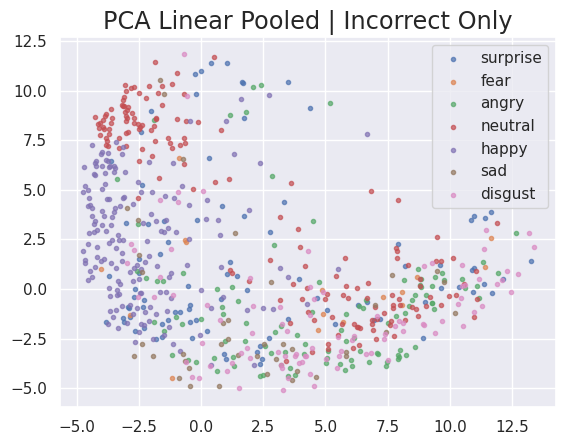

In [19]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=False,
        incorrect_only=True,
        title="PCA Linear Pooled | Incorrect Only",
        n_sampling=0,
        random_state=42)

## TSNE

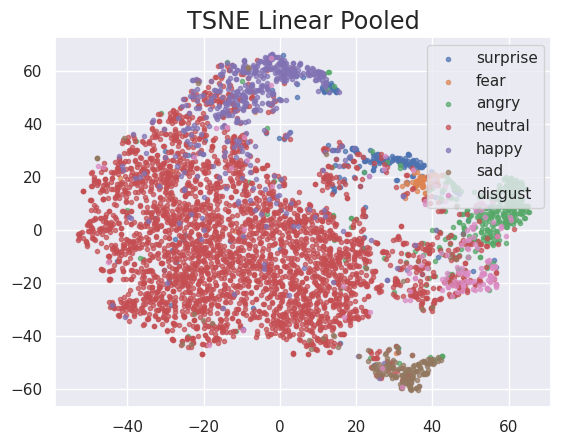

In [22]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=False,
        incorrect_only=False,
        title="TSNE Linear Pooled",
        n_sampling=0,
        random_state=42)

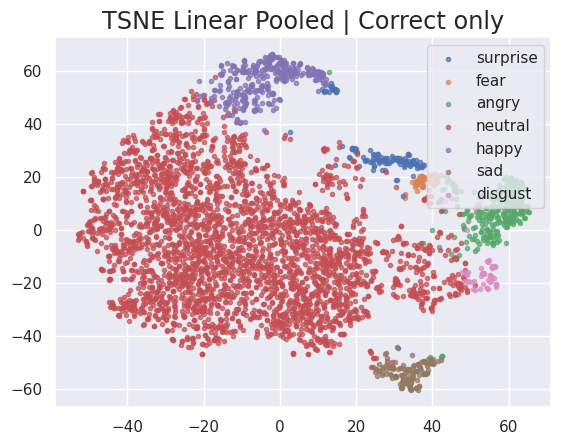

In [23]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=True,
        incorrect_only=False,
        title="TSNE Linear Pooled | Correct only",
        n_sampling=0,
        random_state=42)

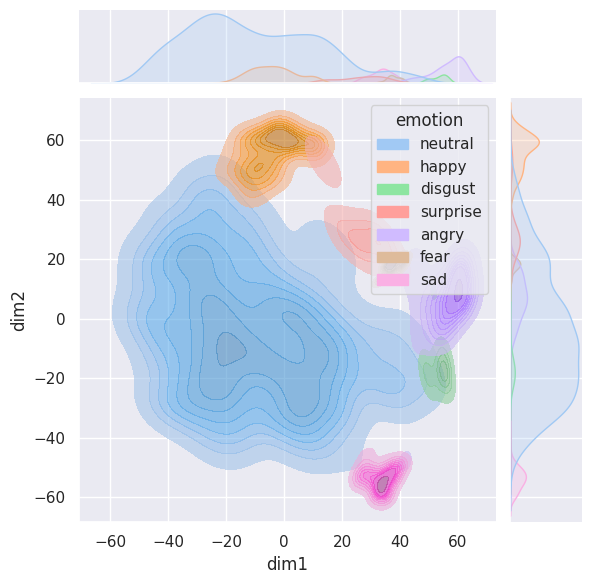

In [34]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=True,
        incorrect_only=False,
        title="TSNE Linear Pooled | Correct only",
        n_sampling=0,
        use_jointplot=True,
        random_state=42)

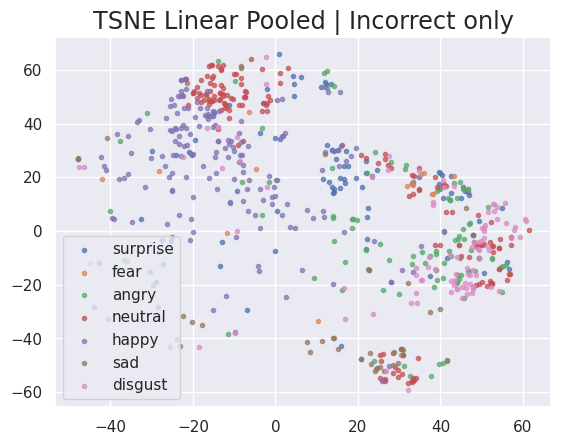

In [24]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=False,
        incorrect_only=True,
        title="TSNE Linear Pooled | Incorrect only",
        n_sampling=0,
        random_state=42)

## UMAP

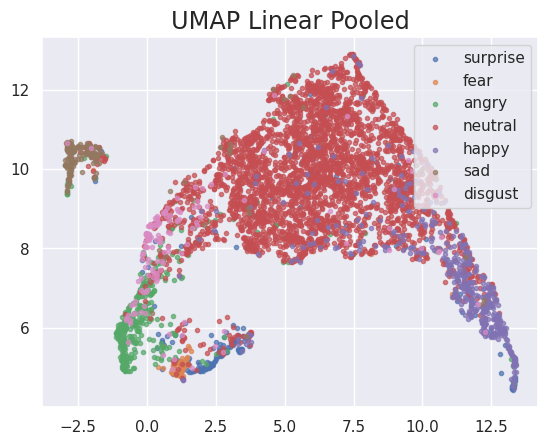

In [25]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=False,
        incorrect_only=False,
        title="UMAP Linear Pooled",
        n_sampling=0,
        random_state=42)

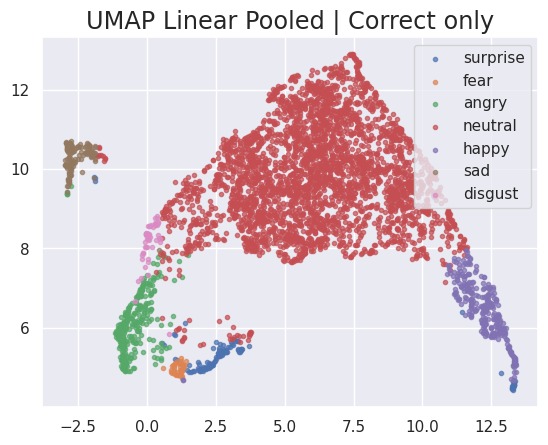

In [26]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        random_state=42)

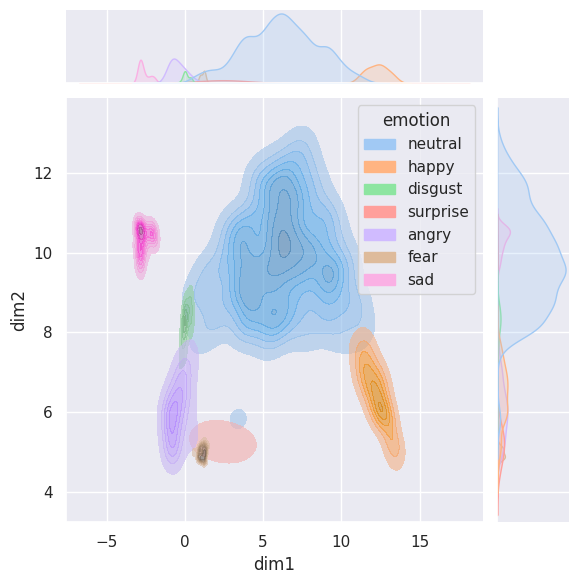

In [35]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        use_jointplot=True,
        random_state=42)

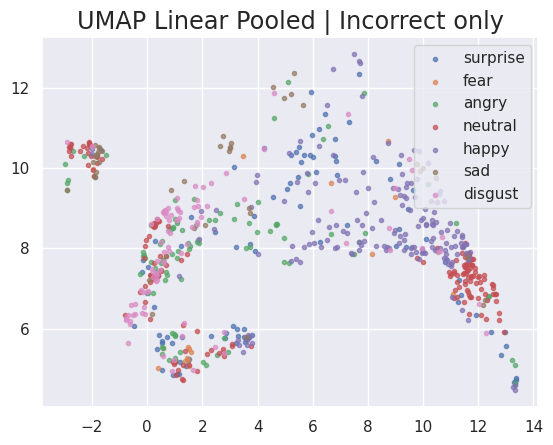

In [27]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=False,
        incorrect_only=True,
        title="UMAP Linear Pooled | Incorrect only",
        n_sampling=0,
        random_state=42)